In [87]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from statistics import mean
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, cross_validate, RandomizedSearchCV, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, make_scorer, fbeta_score
from sklego.preprocessing import InformationFilter
from sklego.metrics import p_percent_score, equal_opportunity_score

In [3]:
from sklearn.linear_model import LogisticRegression
from sklego.linear_model import DemographicParityClassifier
from sklego.linear_model import EqualOpportunityClassifier

In [4]:
# NOTE: we are using demographic parity of our measure of fairness (equal probility of approval across sensitive attribute),
# sklego has a metric called p_percent_score that quantifies this measure of fairness
# However, the sensitive variable must be in the dataset that the model is trained on in order to calculate
# p_percent_score using sklego's p_percent_score
# Therefore, because we want to benchmark fairness with a model that uses an information filter on gender, as well as
# a model that drops gender prior to training (fairness through unawareness), I have created my own function that 
# calculates p % scores without requiring gender to be present in the dataset when training the model

def my_p_percent(model, xtrain, df, z):
    y_hat = model.predict(xtrain)
    y_hat_z0 = []
    y_hat_z1 = []
    
    for i in range(len(y_hat)):
    #check if xtrain index corresponds to z0 or z1:
        if df.iloc[xtrain.index[i]][z] == 0:
            y_hat_z0.append(y_hat[i])
        else:
            y_hat_z1.append(y_hat[i])
    y_hat_z0_pos_target = []
    y_hat_z1_pos_target = []
    
    for pred in y_hat_z0:
        if pred == 1:
            y_hat_z0_pos_target.append(pred)
    
    for pred in y_hat_z1:
        if pred == 1:
            y_hat_z1_pos_target.append(pred)
            
    p_y1_z0 = len(y_hat_z0_pos_target)/len(y_hat_z0)
    p_y1_z1 = len(y_hat_z1_pos_target)/len(y_hat_z1)
    
    return np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)

# German Credit Dataset

## data loading/manipulation

In [5]:
# column names
cols = ['existing_checking', 'duration(months)', 'credit_history', 'purpose', 'credit_amount',
         'savings_account', 'employment_since', 'installment_rate', 'status_and_sex', 'other_debtors',
         'residence_since', 'property', 'age', 'other_installment_plans', 'housing',
         'existing_credits', 'job', 'people_liable', 'telephone', 'foreign_worker', 'classification']

In [6]:
# load data
df=pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data", names= cols, delimiter=' ')

In [7]:
df.head(10)

,existing_checking,duration(months),credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,status_and_sex,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,people_liable,telephone,foreign_worker,classification
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
5,A14,36,A32,A46,9055,A65,A73,2,A93,A101,...,A124,35,A143,A153,1,A172,2,A192,A201,1
6,A14,24,A32,A42,2835,A63,A75,3,A93,A101,...,A122,53,A143,A152,1,A173,1,A191,A201,1
7,A12,36,A32,A41,6948,A61,A73,2,A93,A101,...,A123,35,A143,A151,1,A174,1,A192,A201,1
8,A14,12,A32,A43,3059,A64,A74,2,A91,A101,...,A121,61,A143,A152,1,A172,1,A191,A201,1
9,A12,30,A34,A40,5234,A61,A71,4,A94,A101,...,A123,28,A143,A152,2,A174,1,A191,A201,2


In [8]:
# numerical features
num_features = ['credit_amount', 'duration(months)', 'installment_rate', 'residence_since', 'age',
           'existing_credits', 'people_liable']

In [9]:
# normalize data
df[num_features] = StandardScaler().fit_transform(df[num_features])

In [10]:
# categorical features
cat_features = ['existing_checking', 'credit_history', 'purpose', 'savings_account', 'employment_since',
            'other_debtors', 'property', 'other_installment_plans', 'housing', 'job',
           'telephone', 'foreign_worker']

## Feature Engineering: Attribute 9

### Reference of Attribute 9:
```
Attribute 9: (qualitative)
Personal status and sex
A91 : male : divorced/separated
A92 : female : divorced/separated/married
A93 : male : single
A94 : male : married/widowed
A95 : female : single 
```

In [11]:
# NOTE: given that we're treating gender as the sensitive varibale, we decided to separate 
# attribute 9 (sex_and_status) into two distinct variables: 1. gender 2. personal_status
# Isolating the gender variable allows us to build a model with a fairness constraint on gender

In [12]:
# create gender column and personal_status column
df['gender'] = np.nan
df['personal_status'] = np.nan

In [13]:
# separate attribute 9 (sex_and_status) into two columns: gender, personal_status
for index, row in df.iterrows():
    if row['status_and_sex'] == 'A91':
        # male
        df.loc[index, 'gender'] = 0

        # divorced/separated
        df.loc[index, 'personal_status'] = 1

        #print('mutated row = ', df.iloc[index])
    if row['status_and_sex'] == 'A92':
        # female
        df.loc[index, 'gender'] = 1
        # divorced/separated/married
        df.loc[index, 'personal_status'] = 1

    if row['status_and_sex'] == 'A93':
        # male
        df.loc[index, 'gender'] = 0
        # single
        df.loc[index, 'personal_status'] = 0

    if row['status_and_sex'] == 'A94':
        # male
        df.loc[index, 'gender'] = 0
        # married/widowed
        df.loc[index, 'personal_status'] = 1

    if row['status_and_sex'] == 'A95':
        # female
        df.loc[index, 'gender'] = 1
        # single
        df.loc[index, 'personal_status'] = 0

In [14]:
# check to make sure gender column now exists:
df['gender']

0      0.0
1      1.0
2      0.0
3      0.0
4      0.0
      ... 
995    1.0
996    0.0
997    0.0
998    0.0
999    0.0
Name: gender, Length: 1000, dtype: float64

In [15]:
# check to make sure personal_status column now exists:
df['personal_status']

0      0.0
1      1.0
2      0.0
3      0.0
4      0.0
      ... 
995    1.0
996    1.0
997    0.0
998    0.0
999    0.0
Name: personal_status, Length: 1000, dtype: float64

In [16]:
# gain insight into the distribution of approvals for men and women
approved_men = 0
approved_women = 0
for index, row in df.iterrows():
    if row['gender'] == 0 and row['classification'] == 1:
        approved_men += 1
    if row['gender'] == 1 and row['classification'] == 1:
        approved_women += 1
print('# of approved men = ', approved_men)
print('# of approved women = ', approved_women)

# of approved men =  499
# of approved women =  201


In [17]:
# now that we've separated sex_status into two columns, we can now delete the sex_status column
df = df.drop('status_and_sex', axis=1)

In [18]:
# one-hot encoding each of every categorical features
df = pd.get_dummies(df, columns = cat_features)

In [19]:
# replace labels with 1=good, 0=bad
df.classification.replace([1,2], [1,0], inplace=True)

# Benchmarking: 
## There are three ways we would like to train our data in order to create benchmarks:
### 1. Dataset containing all original information (including gender)
### 2. Dataset not containing gender (fairness through unawareness) 
### 3. Dataset with information filter on gender column

In [20]:
# define x as all columns except for last column which contains labels
x = df.drop('classification', axis = 1)

# fairness through unaware benchmark comparison (dropping gender column prior to training)
x_unaware = df.drop(['classification', 'gender'], axis = 1)

# information filter on gender column
x_infoFilter = InformationFilter('gender').fit_transform(x)
x_infoFilter = pd.DataFrame(x_infoFilter, columns=[n for n in x.columns if n not in ['gender']])

In [21]:
y = df.classification

In [22]:
# 80/20 split for train/test
#xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state = 0)

#xtrain_unaware, xtest_unware, ytrain_unaware, ytest_unware = train_test_split(x_unaware, y, test_size = 0.2, random_state = 0)

#xtrain_infoFilter, xtest_infoFilter, ytrain_infoFilter, ytest_infoFilter = train_test_split(x_infoFilter, y, test_size = 0.2, random_state = 0)

In [23]:
# define cross-validation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [24]:
# model evaluation metrics 
f2 = make_scorer(fbeta_score, beta=2)
mean_accuracy=[]
mean_f2=[]
mean_precision=[]
mean_recall=[]
accuracy_std=[]
p_percents=[]
equal_opp=[]

In [25]:
# baseline model evaluation metrics
f2_unaware = make_scorer(fbeta_score, beta=2)
mean_accuracy_unaware=[]
mean_f2_unaware=[]
mean_precision_unaware=[]
mean_recall_unaware=[]
accuracy_std_unaware=[]
p_percents_unaware=[]
equal_opp_unaware=[]

In [26]:
# information filter model evaluation metrics
f2_infoFilter = make_scorer(fbeta_score, beta=2)
mean_accuracy_infoFilter=[]
mean_f2_infoFilter=[]
mean_precision_infoFilter=[]
mean_recall_infoFilter=[]
accuracy_std_infoFilter=[]
p_percents_infoFilter=[]
equal_opp_infoFilter=[]

In [27]:
# classifiers
classifiers=['Logistic Regression', 'Demographic Parity Cov_Threshold=1', 'Demographic Parity Cov_Threshold=0.0000069', 'Equal Opportunity']
models=[LogisticRegression(max_iter=5000), DemographicParityClassifier(sensitive_cols="gender", covariance_threshold=1), DemographicParityClassifier(sensitive_cols="gender", covariance_threshold=0.0000069), EqualOpportunityClassifier(sensitive_cols="gender", covariance_threshold=0.0000069, positive_target=True,)]

In [28]:
for model in models:
    # accuracy
    cv_accuracy = cross_val_score(model,x,y,scoring = "accuracy", cv = cv, n_jobs=-1)
    # f2beta
    cv_f2 = cross_val_score(model, x, y, scoring=f2, cv=cv, n_jobs=-1)
    # precision
    cv_precision = cross_val_score(model, x, y, scoring='precision', cv=cv, n_jobs=-1)
    # recall
    cv_recall = cross_val_score(model, x, y, scoring='recall', cv=cv, n_jobs=-1)
    #p% 
    model.fit(x, y)
    p_percent = p_percent_score(sensitive_column="gender")(model, x)
    equal_opp_score = equal_opportunity_score(sensitive_column="gender")(model, x, y)


    mean_accuracy.append(mean(cv_accuracy))
    accuracy_std.append(cv_accuracy.std())
    mean_f2.append(mean(cv_f2))
    mean_precision.append(mean(cv_precision))
    mean_recall.append(mean(cv_recall))
    p_percents.append(p_percent)
    equal_opp.append(equal_opp_score)

In [29]:
models_dataframe=pd.DataFrame({'Mean Accuracy':mean_accuracy, 'Accuracy Std':accuracy_std, 'Mean f2beta': mean_f2, 'Mean precision':mean_precision, 'Mean recall':mean_recall, 'P%':p_percents, 'Equal Opp Score':equal_opp},index=classifiers)

In [30]:
# classifiers for information filter and fairness through unawareness evaluation 
classifiers_=['Logistic Regression']
models_ = models=[LogisticRegression(max_iter=5000)]

In [31]:
for model in models_:
    # accuracy
    cv_accuracy = cross_val_score(model,x_infoFilter,y,scoring = "accuracy", cv = cv, n_jobs=-1)
    # f2beta
    cv_f2 = cross_val_score(model, x_infoFilter, y, scoring=f2, cv=cv, n_jobs=-1)
    # precision
    cv_precision = cross_val_score(model, x_infoFilter, y, scoring='precision', cv=cv, n_jobs=-1)
    # recall
    cv_recall = cross_val_score(model, x_infoFilter, y, scoring='recall', cv=cv, n_jobs=-1)
    
    model.fit(x_infoFilter, y)
    p_percent_infoFilter = my_p_percent(model, x_infoFilter, df, z="gender" )

    mean_accuracy_infoFilter.append(mean(cv_accuracy))
    accuracy_std_infoFilter.append(cv_accuracy.std())
    mean_f2_infoFilter.append(mean(cv_f2))
    mean_precision_infoFilter.append(mean(cv_precision))
    mean_recall_infoFilter.append(mean(cv_recall))
    p_percents_infoFilter.append(p_percent_infoFilter)

In [32]:
models_dataframe_infoFilter=pd.DataFrame({'Information filter Mean Accuracy':mean_accuracy_infoFilter, 'Information filter Accuracy Std':accuracy_std_infoFilter, 'Information filter Mean f2beta': mean_f2_infoFilter, 'Information filter Mean precision':mean_precision_infoFilter, 'Information filter Mean recall':mean_recall_infoFilter, 'P %': p_percents_infoFilter},index=classifiers_)

In [33]:
# baseline comparision (fairness through unawareness)

for model in models_:
    # accuracy
    cv_accuracy_unaware = cross_val_score(model,x_unaware,y,scoring = "accuracy", cv = cv, n_jobs=-1)
    # f2beta
    cv_f2_unaware = cross_val_score(model, x_unaware, y, scoring=f2, cv=cv, n_jobs=-1)
    # precision
    cv_precision_unaware = cross_val_score(model, x_unaware, y, scoring='precision', cv=cv, n_jobs=-1)
    # recall
    cv_recall_unaware = cross_val_score(model, x_unaware, y, scoring='recall', cv=cv, n_jobs=-1)
    
    model.fit(x_unaware, y)
    p_percent_unaware = my_p_percent(model, x_unaware, df, z="gender" )
    
    
    mean_accuracy_unaware.append(mean(cv_accuracy_unaware))
    accuracy_std_unaware.append(cv_accuracy_unaware.std())
    mean_f2_unaware.append(mean(cv_f2_unaware))
    mean_precision_unaware.append(mean(cv_precision_unaware))
    mean_recall_unaware.append(mean(cv_recall_unaware))
    p_percents_unaware.append(p_percent_unaware)

In [34]:
models_dataframe_unaware=pd.DataFrame({'Baseline Mean Accuracy':mean_accuracy_unaware, 'Baseline Accuracy Std':accuracy_std_unaware, 'Baseline Mean f2beta': mean_f2_unaware, 'Baseline Mean Precision':mean_precision_unaware, 'Baseline Mean recall':mean_recall_unaware, 'P %': p_percents_unaware},index=classifiers_)

## Benchmark Results

In [35]:
# results for models training using original dataset (gender column included)
models_dataframe

,Mean Accuracy,Accuracy Std,Mean f2beta,Mean precision,Mean recall,P%,Equal Opp Score
Logistic Regression,0.761000,0.031660,0.861042,0.800754,0.878095,0.855157,0.943929
Demographic Parity Cov_Threshold=1,0.760667,0.033460,0.860040,0.801215,0.876667,0.842197,0.929603
Demographic Parity Cov_Threshold=0.0000069,0.756000,0.031581,0.856983,0.797557,0.873810,0.989247,0.958852
Equal Opportunity,0.752667,0.033559,0.852824,0.796853,0.868571,0.998215,0.955288


In [36]:
# results for model trained using information filter on gender
models_dataframe_infoFilter

,Information filter Mean Accuracy,Information filter Accuracy Std,Information filter Mean f2beta,Information filter Mean precision,Information filter Mean recall,P %
Logistic Regression,0.760667,0.030977,0.860956,0.80043,0.878095,0.856695


In [37]:
# results for model trained without gender column (fairness through unawareness), intended as a baseline comparison
models_dataframe_unaware

,Baseline Mean Accuracy,Baseline Accuracy Std,Baseline Mean f2beta,Baseline Mean Precision,Baseline Mean recall,P %
Logistic Regression,0.76,0.032558,0.860187,0.800209,0.877143,0.855157


# Exploration of covariance threshold: Demographic Parity Classifier 

In [38]:
dpc_clf = DemographicParityClassifier(sensitive_cols="gender", covariance_threshold=0.5)

In [39]:
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [40]:
grid_dpc = GridSearchCV(estimator=dpc_clf, param_grid={"estimator__covariance_threshold":np.linspace(0, 1.00, 50)}, cv=6, return_train_score=True, refit="p_percent_score", scoring={"p_percent_score":p_percent_score('gender'), "accuracy_score":make_scorer(accuracy_score)})

In [41]:
grid_dpc.fit(x,y)

GridSearchCV(cv=6,
             estimator=OneVsRestClassifier(estimator=_DemographicParityClassifier(covariance_threshold=0.5,
                                                                                  sensitive_cols='gender'),
                                           n_jobs=1),
             param_grid={'estimator__covariance_threshold': array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.285...
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])},
             refit='p_percent_score', return_train_score=True,
             scoring={'accuracy_score': make_scorer(accuracy_score),
                      'p_percent_score': <function

In [42]:
results_dpc = (pd.DataFrame(grid_dpc.cv_results_).set_index("param_estimator__covariance_threshold"))

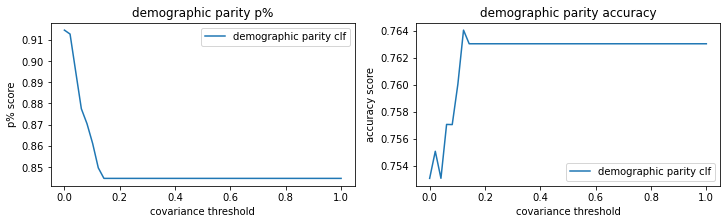

In [43]:
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.plot(np.array(results_dpc.index), results_dpc['mean_test_p_percent_score'], label='demographic parity clf')
plt.xlabel("covariance threshold")
plt.ylabel('p% score')
plt.legend()
plt.title("demographic parity p%")
plt.subplot(122)
plt.plot(np.array(results_dpc.index), results_dpc['mean_test_accuracy_score'], label='demographic parity clf')
plt.xlabel("covariance threshold")
plt.ylabel('accuracy score')
plt.legend()
plt.title("demographic parity accuracy");

In [44]:
# NOTE: it's clear that p% is influenced by covariance threshold for dpc model, which makes sense given 
# that cov_threshold represents the maximum allowed covariance between the sensitive attributes and the 
# distance to the decision boundary. 
# Thus, it would be interesting to explore how feature coefficients change as covariance threshold changes

## Exploration of how feature coefficients change as a function of covariance threshold 

In [45]:
dpc = DemographicParityClassifier(sensitive_cols="gender", covariance_threshold=1)

In [46]:
dpc.fit(x, y)

OneVsRestClassifier(estimator=_DemographicParityClassifier(covariance_threshold=1,
                                                           sensitive_cols='gender'),
                    n_jobs=1)

In [48]:
dpc_features = x.columns.drop('gender')

In [110]:
# confirming that I can assign all features to their corresponding coefficients 
coef_dict = {}
for coef, feat in zip(dpc.coef_[0,:],dpc_features):
    coef_dict[feat] = coef
coef_dict

{'duration(months)': -0.33786868476164805,
 'credit_amount': -0.35726536837699185,
 'installment_rate': -0.3594758173177607,
 'residence_since': -0.004201731525635283,
 'age': 0.15272118691874087,
 'existing_credits': -0.15157222527834363,
 'people_liable': -0.09454276763553268,
 'personal_status': -0.5476509857620888,
 'existing_checking_A11': -0.756681493116547,
 'existing_checking_A12': -0.37474523500290646,
 'existing_checking_A13': 0.18491105426499244,
 'existing_checking_A14': 0.9465156738609733,
 'credit_history_A30': -0.5232760847615877,
 'credit_history_A31': -0.658313326678301,
 'credit_history_A32': 0.035092368784475296,
 'credit_history_A33': 0.2809559327834713,
 'credit_history_A34': 0.8655411098780548,
 'purpose_A40': -0.7877501107092298,
 'purpose_A41': 0.8454347663985474,
 'purpose_A410': 0.5727038514160212,
 'purpose_A42': -0.0320332100486613,
 'purpose_A43': 0.10620030308078639,
 'purpose_A44': -0.2281138244021877,
 'purpose_A45': -0.5405683820858171,
 'purpose_A46': 

In [111]:
# create dictionary where keys are features, and values are an empty list (to be populated later on)
feature_dict = {}
for feat in dpc_features:
    feature_dict[feat] = []
feature_dict

{'duration(months)': [],
 'credit_amount': [],
 'installment_rate': [],
 'residence_since': [],
 'age': [],
 'existing_credits': [],
 'people_liable': [],
 'personal_status': [],
 'existing_checking_A11': [],
 'existing_checking_A12': [],
 'existing_checking_A13': [],
 'existing_checking_A14': [],
 'credit_history_A30': [],
 'credit_history_A31': [],
 'credit_history_A32': [],
 'credit_history_A33': [],
 'credit_history_A34': [],
 'purpose_A40': [],
 'purpose_A41': [],
 'purpose_A410': [],
 'purpose_A42': [],
 'purpose_A43': [],
 'purpose_A44': [],
 'purpose_A45': [],
 'purpose_A46': [],
 'purpose_A48': [],
 'purpose_A49': [],
 'savings_account_A61': [],
 'savings_account_A62': [],
 'savings_account_A63': [],
 'savings_account_A64': [],
 'savings_account_A65': [],
 'employment_since_A71': [],
 'employment_since_A72': [],
 'employment_since_A73': [],
 'employment_since_A74': [],
 'employment_since_A75': [],
 'other_debtors_A101': [],
 'other_debtors_A102': [],
 'other_debtors_A103': [],

In [95]:
cov_threshold = np.linspace(0,1,60)

In [96]:
# build demographic parity models with 60 different covariance thresholds, storing each corresponding
# feature coefficient in the above dictionary, allowing us to see how each feature's coefficients change as a function
# of covariance threshold 
for cov in cov_threshold:
    model = DemographicParityClassifier(sensitive_cols="gender", covariance_threshold=cov)
    model.fit(x, y)
    p_percent = p_percent_score(sensitive_column="gender")(model, x)
    for coef, feat in zip(model.coef_[0,:],dpc_features):
        #print('cov = ', cov)
        #print('feat = ', feat)
        #print('coef = ', coef)
        #feature_dict[feat].append({cov:[coef,p_percent]})
        feature_dict[feat].append([cov,coef,p_percent])

In [97]:
# format = {'feature': [covariance threshold, feature coef, p_percent]}
feature_dict

{'duration(months)': [[0.0, -0.3326490096408497, 0.9892473118279569],
  [0.01694915254237288, -0.3327279994340602, 0.9586806814063067],
  [0.03389830508474576, -0.3330639314688965, 0.9267298237198704],
  [0.05084745762711865, -0.3336572122253413, 0.9075705273181764],
  [0.06779661016949153, -0.33450773263949307, 0.9058991267153805],
  [0.0847457627118644, -0.3356148651742885, 0.8838357130266173],
  [0.1016949152542373, -0.33697749438927743, 0.8548387096774193],
  [0.11864406779661017, -0.3378686846531419, 0.8421970357454228],
  [0.13559322033898305, -0.3378686847850163, 0.8421970357454228],
  [0.15254237288135594, -0.3378686847758293, 0.8421970357454228],
  [0.1694915254237288, -0.3378686847749136, 0.8421970357454228],
  [0.1864406779661017, -0.3378686847749664, 0.8421970357454228],
  [0.2033898305084746, -0.3378686847750102, 0.8421970357454228],
  [0.22033898305084745, -0.3378686847753243, 0.8421970357454228],
  [0.23728813559322035, -0.3378686847741233, 0.8421970357454228],
  [0.2542

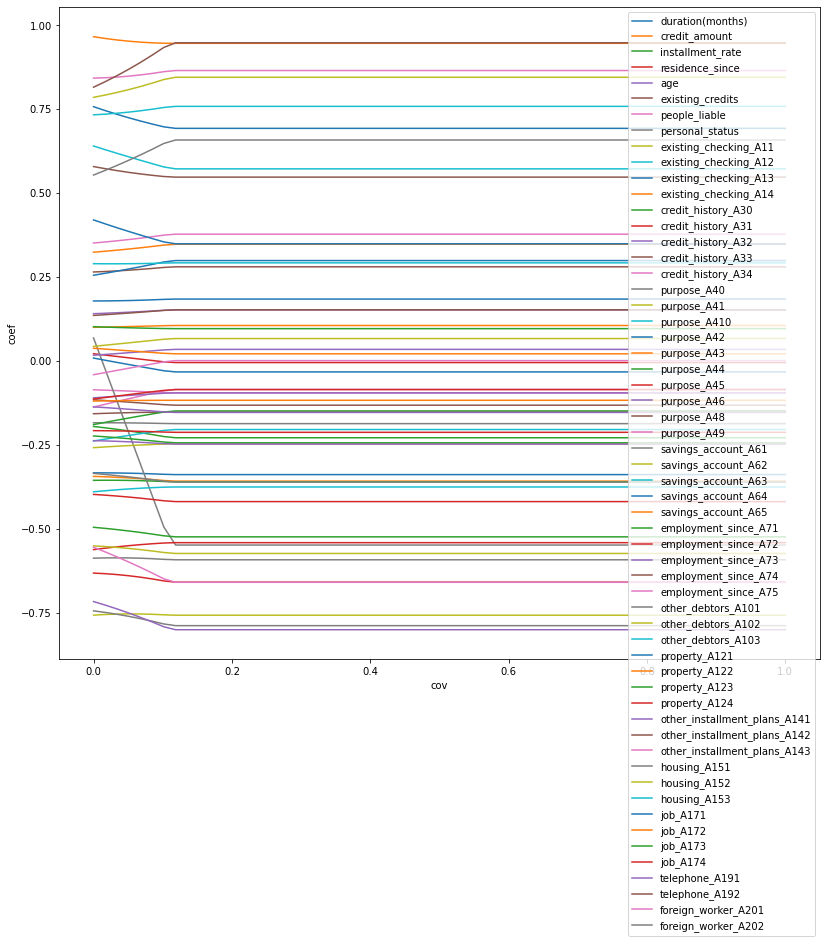

In [98]:
plt.figure(figsize=(30,12))
plt.subplot(121)

for feature in feature_dict:
    xs = [x[0] for x in feature_dict[feature]]
    ys = [x[1] for x in feature_dict[feature]]
    plt.plot(xs,ys,label=feature)
plt.xlabel("cov")
plt.ylabel('coef')
plt.legend()

In [ ]:
# NOTE: all feature coefficients flatline slightly before a covariance threshold of 0.2

In [112]:
cov_threshold = np.linspace(0.0,0.2, 30)

In [113]:
for cov in cov_threshold:
    model = DemographicParityClassifier(sensitive_cols="gender", covariance_threshold=cov)
    model.fit(x, y)
    p_percent = p_percent_score(sensitive_column="gender")(model, x)
    for coef, feat in zip(model.coef_[0,:],dpc_features):
        feature_dict[feat].append([cov,coef,p_percent])

In [114]:
# format = {'feature': [covariance threshold, feature coef, p_percent]}
feature_dict

{'duration(months)': [[0.0, -0.3326490096408497, 0.9892473118279569],
  [0.006896551724137932, -0.3326501962421167, 0.9664685908319184],
  [0.013793103448275864, -0.3326938433824109, 0.9586806814063067],
  [0.020689655172413796, -0.3327800189788263, 0.9509508907077516],
  [0.027586206896551727, -0.332908760552219, 0.9326004685528925],
  [0.03448275862068966, -0.3330801064369393, 0.9267298237198704],
  [0.04137931034482759, -0.33329406230194697, 0.9174765965058733],
  [0.048275862068965524, -0.3335506364083109, 0.911677181287942],
  [0.055172413793103454, -0.3338498144620182, 0.9075705273181764],
  [0.062068965517241385, -0.3341915686680226, 0.9042338709677419],
  [0.06896551724137932, -0.3345758567617589, 0.9058991267153805],
  [0.07586206896551725, -0.3350026300261654, 0.8952055198443121],
  [0.08275862068965519, -0.3354718161747235, 0.8895102425241346],
  [0.08965517241379312, -0.33598333443296974, 0.8797814207650273],
  [0.09655172413793105, -0.33653709196500936, 0.8685088695041274]

In [115]:
# creating a pandas df for each feature
df_list = []
delta_list = []
for feature in feature_dict:
    df = pd.DataFrame(data = feature_dict[feature], columns = ["cov", f"{feature}_coef", "p percent"])
    df.sort_values('p percent')
    df = df.reset_index(drop=True)
    most_fair = df.at[0,f"{feature}_coef"]
    print('df = ', df)
    least_fair = df.at[29, f"{feature}_coef"]
    fairness_delta = most_fair - least_fair
    delta_list.append(fairness_delta)
    
feature_fairness_delta = list(zip(feature_dict.keys(),delta_list))
feature_fairness_delta_sort = sorted(feature_fairness_delta, key=lambda x : x[1])
#feature_fairness_delta_sort
features = []
delta_coef = []
for item in feature_fairness_delta_sort:
    features.append(item[0])
    delta_coef.append(item[1])


df =           cov  duration(months)_coef  p percent
0   0.000000              -0.332649   0.989247
1   0.006897              -0.332650   0.966469
2   0.013793              -0.332694   0.958681
3   0.020690              -0.332780   0.950951
4   0.027586              -0.332909   0.932600
5   0.034483              -0.333080   0.926730
6   0.041379              -0.333294   0.917477
7   0.048276              -0.333551   0.911677
8   0.055172              -0.333850   0.907571
9   0.062069              -0.334192   0.904234
10  0.068966              -0.334576   0.905899
11  0.075862              -0.335003   0.895206
12  0.082759              -0.335472   0.889510
13  0.089655              -0.335983   0.879781
14  0.096552              -0.336537   0.868509
15  0.103448              -0.337133   0.854839
16  0.110345              -0.337771   0.843717
17  0.117241              -0.337869   0.842197
18  0.124138              -0.337869   0.842197
19  0.131034              -0.337869   0.842197
20  0.1

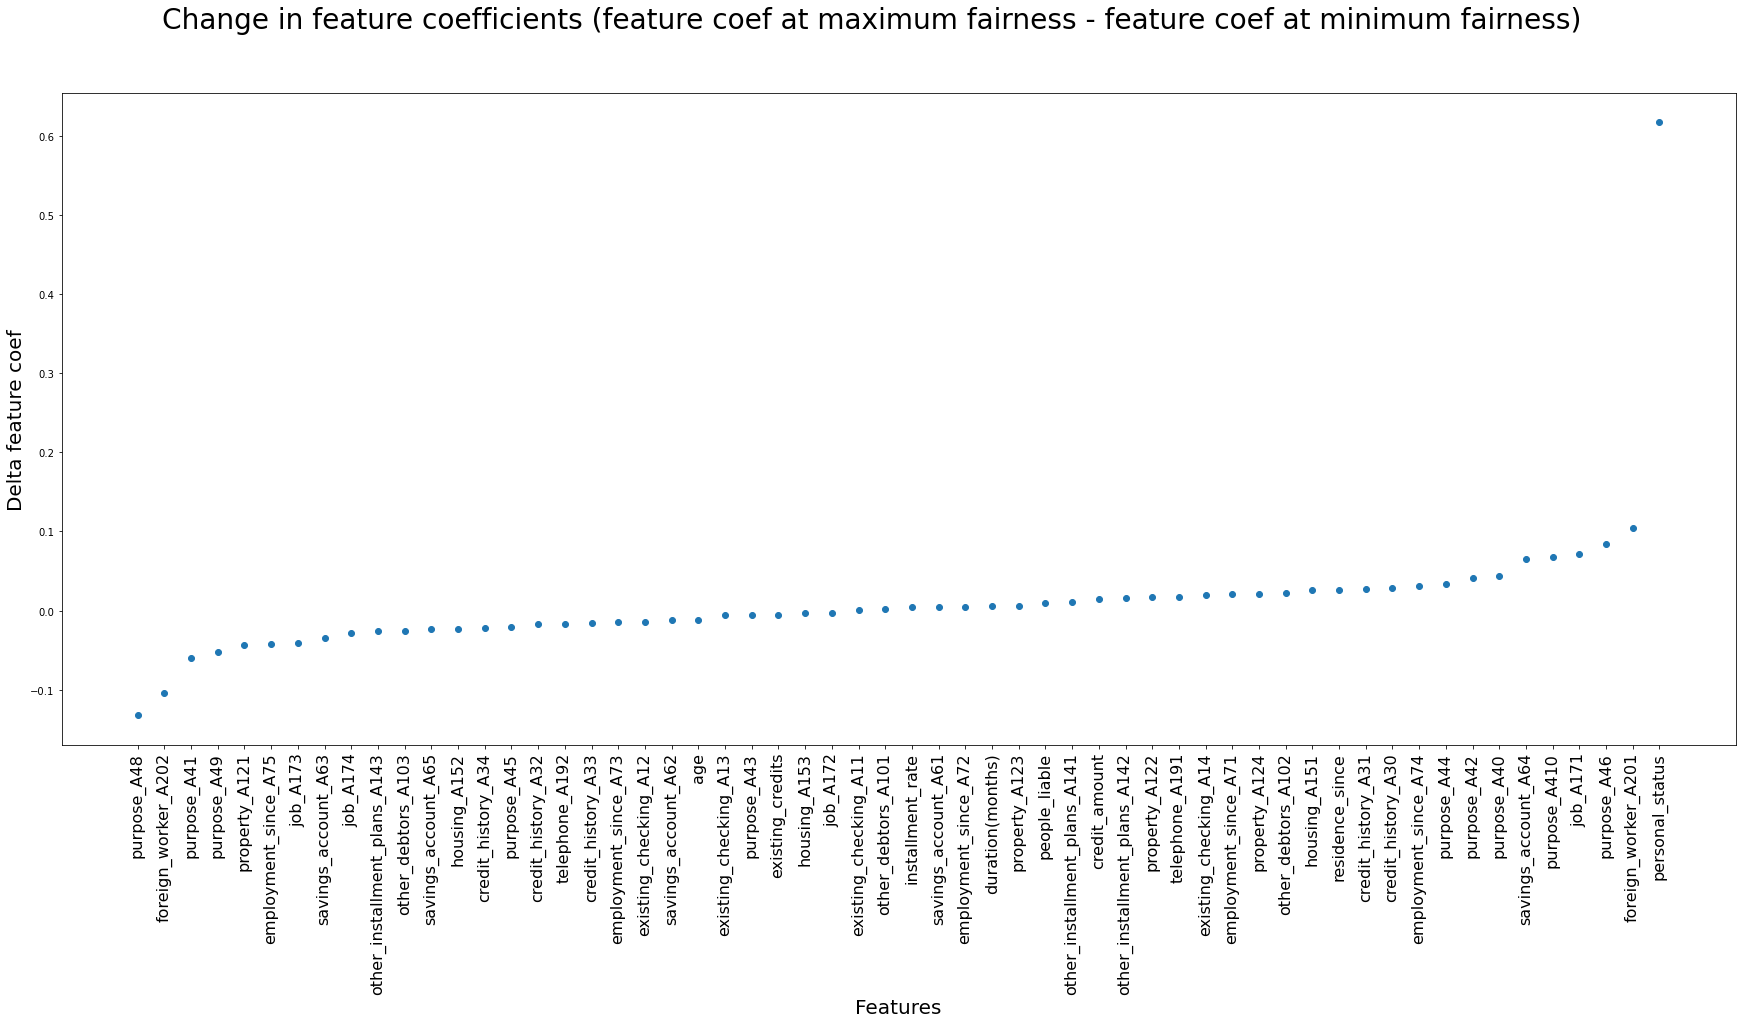

In [116]:
figure, ax = plt.subplots(figsize=(30,12))
ax.scatter(features, delta_coef)
xticks_labels = features
ax.set_xticklabels(xticks_labels, rotation=90, fontsize=16)
figure.suptitle('Change in feature coefficients (feature coef at maximum fairness - feature coef at minimum fairness)', fontsize=28)
plt.xlabel("Features", fontsize=20)
plt.ylabel('Delta feature coef', fontsize=20)
plt.show()


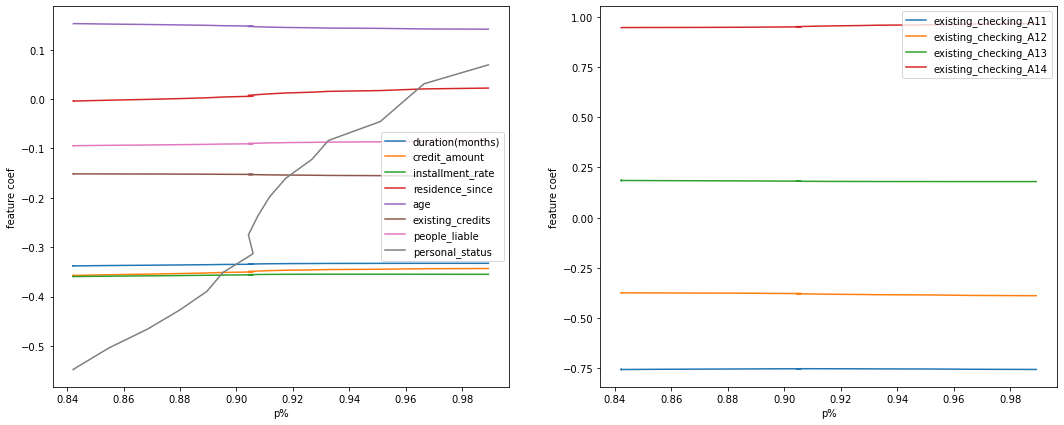

In [117]:
plt.figure(figsize=(18,7))
plt.subplot(121)

for feature in ['duration(months)', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'existing_credits', 'people_liable', 'personal_status']:
    xs = [x[2] for x in feature_dict[feature]]
    ys = [x[1] for x in feature_dict[feature]]
    plt.plot(xs,ys,label=feature)
    
plt.xlabel("p%")
plt.ylabel('feature coef')
plt.legend()
plt.subplot(122)
for feature in ['existing_checking_A11', 'existing_checking_A12', 'existing_checking_A13', 'existing_checking_A14']:
    xs = [x[2] for x in feature_dict[feature]]
    ys = [x[1] for x in feature_dict[feature]]
    plt.plot(xs,ys,label=feature)
plt.xlabel("p%")
plt.ylabel('feature coef')
plt.legend()

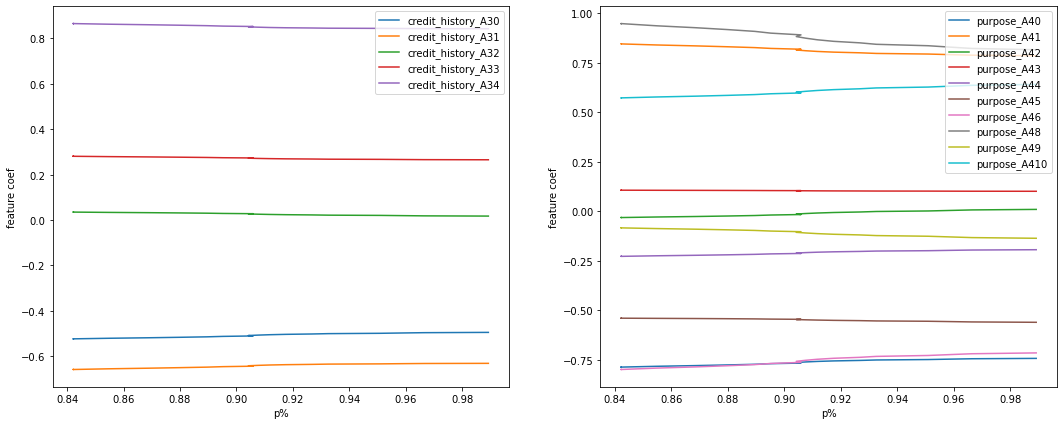

In [118]:
plt.figure(figsize=(18,7))
plt.subplot(121)

for feature in ['credit_history_A30', 'credit_history_A31', 'credit_history_A32', 'credit_history_A33', 'credit_history_A34']:
    xs = [x[2] for x in feature_dict[feature]]
    ys = [x[1] for x in feature_dict[feature]]
    plt.plot(xs,ys,label=feature)
    
plt.xlabel("p%")
plt.ylabel('feature coef')
plt.legend()

plt.subplot(122)
for feature in ['purpose_A40', 'purpose_A41', 'purpose_A42', 'purpose_A43', 'purpose_A44', 'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49', 'purpose_A410']:
    xs = [x[2] for x in feature_dict[feature]]
    ys = [x[1] for x in feature_dict[feature]]
    plt.plot(xs,ys,label=feature)
    
plt.xlabel("p%")
plt.ylabel('feature coef')
plt.legend()

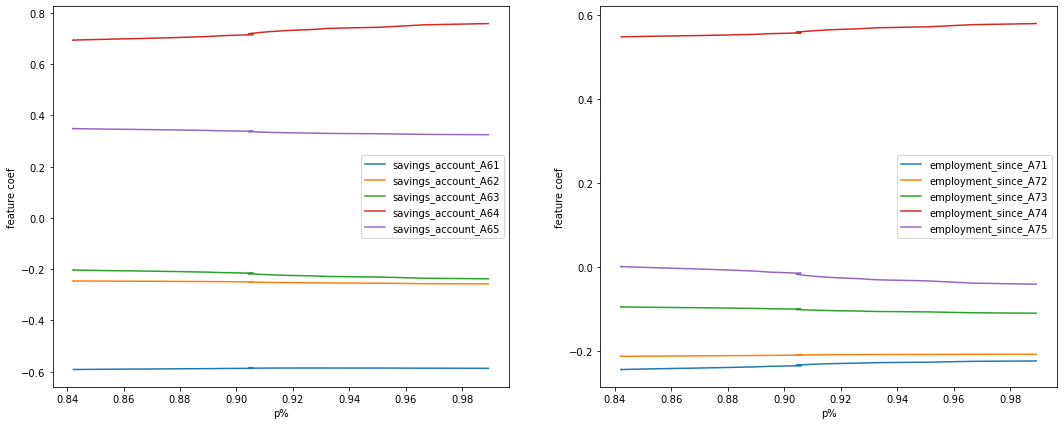

In [119]:
plt.figure(figsize=(18,7))
plt.subplot(121)

for feature in ['savings_account_A61', 'savings_account_A62', 'savings_account_A63', 'savings_account_A64', 'savings_account_A65']:
    xs = [x[2] for x in feature_dict[feature]]
    ys = [x[1] for x in feature_dict[feature]]
    plt.plot(xs,ys,label=feature)
    
plt.xlabel("p%")
plt.ylabel('feature coef')
plt.legend()

plt.subplot(122)
for feature in ['employment_since_A71', 'employment_since_A72', 'employment_since_A73', 'employment_since_A74', 'employment_since_A75']:
    xs = [x[2] for x in feature_dict[feature]]
    ys = [x[1] for x in feature_dict[feature]]
    plt.plot(xs,ys,label=feature)
    
plt.xlabel("p%")
plt.ylabel('feature coef')
plt.legend()

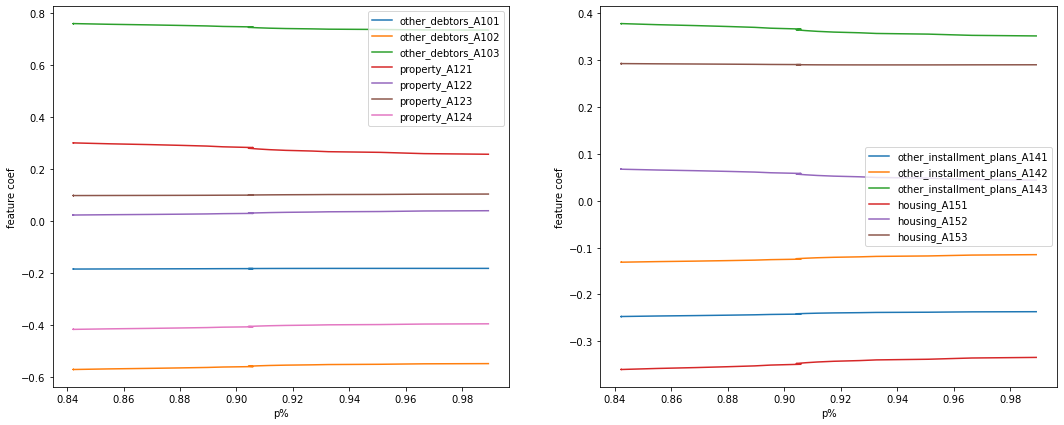

In [120]:
plt.figure(figsize=(18,7))
plt.subplot(121)

for feature in ['other_debtors_A101', 'other_debtors_A102', 'other_debtors_A103', 'property_A121', 'property_A122', 'property_A123', 'property_A124']:
    xs = [x[2] for x in feature_dict[feature]]
    ys = [x[1] for x in feature_dict[feature]]
    plt.plot(xs,ys,label=feature)
    
plt.xlabel("p%")
plt.ylabel('feature coef')
plt.legend()

plt.subplot(122)
for feature in ['other_installment_plans_A141', 'other_installment_plans_A142', 'other_installment_plans_A143', 'housing_A151', 'housing_A152', 'housing_A153']:
    xs = [x[2] for x in feature_dict[feature]]
    ys = [x[1] for x in feature_dict[feature]]
    plt.plot(xs,ys,label=feature)
    
plt.xlabel("p%")
plt.ylabel('feature coef')
plt.legend()

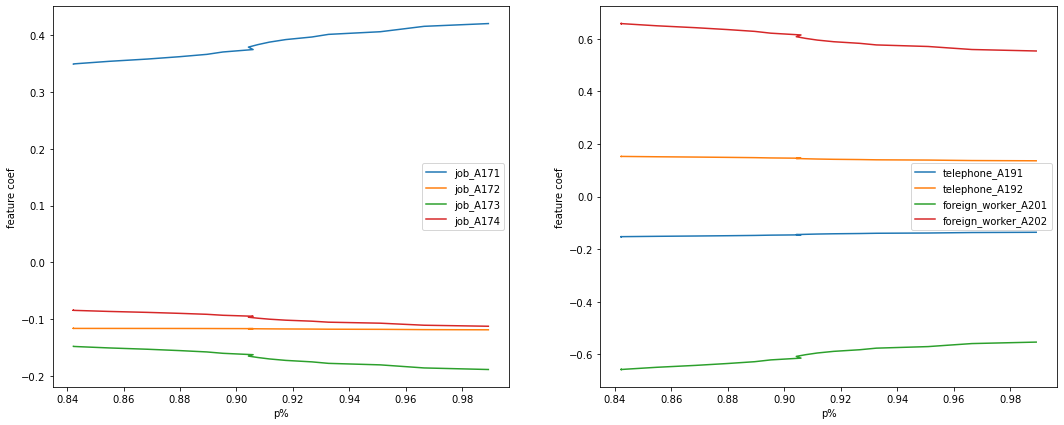

In [121]:
plt.figure(figsize=(18,7))
plt.subplot(121)

for feature in ['job_A171', 'job_A172', 'job_A173', 'job_A174']:
    xs = [x[2] for x in feature_dict[feature]]
    ys = [x[1] for x in feature_dict[feature]]
    plt.plot(xs,ys,label=feature)
    
plt.xlabel("p%")
plt.ylabel('feature coef')
plt.legend()

plt.subplot(122)
for feature in ['telephone_A191', 'telephone_A192', 'foreign_worker_A201', 'foreign_worker_A202']:
    xs = [x[2] for x in feature_dict[feature]]
    ys = [x[1] for x in feature_dict[feature]]
    plt.plot(xs,ys,label=feature)
    
plt.xlabel("p%")
plt.ylabel('feature coef')
plt.legend()